In [975]:
import os
import tifffile
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import linregress
from tqdm import tqdm_notebook as tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scout import utils

# Single-cell morphological features for 6 cell-types

In [977]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50/dataset'

os.listdir(working_dir)

['syto.zarr',
 'Ex0_hist.csv',
 'Ex2_hist.csv',
 'nuclei_binary.zarr',
 'nuclei_probability.zarr',
 'nuclei_fluorescence',
 'segment_ventricles.tif',
 'Ex2_rescaled',
 'nuclei_morphologies.csv',
 'syto_down6x',
 'Ex_1_Em_1_stitched',
 'syto_down6x.tif',
 'niche_labels.npy',
 'Ex_0_Em_0_stitched',
 'Ex1_hist.csv',
 'Ex_2_Em_2_stitched',
 'cyto_profiles.npy',
 'nuclei_foreground.zarr',
 'celltype_names.csv',
 'centroids.npy',
 'nuclei_gating.npy',
 'cyto_profiles_sample.npy',
 'sox2.zarr',
 'niche_names.csv',
 'voxel_size.csv',
 'mesh_ventricles.pkl',
 'nuclei_segmentations.npz',
 'tbr1.zarr',
 'validation',
 'niche_proximities.npy',
 'Ex0_rescaled',
 'segment_foreground.tif',
 'cyto_sample_index.npy',
 'Ex1_rescaled',
 'centroids_um.npy']

In [978]:
df = pd.read_csv(os.path.join(working_dir, 'nuclei_morphologies.csv'))
df = df.drop(labels=['Unnamed: 0'], axis=1)
df.head()

com_z       com_y        com_x  volume   eq_diam  minor_length  \
0  48.563786   74.115226  2068.106996   243.0  7.742286      8.948153   
1  40.668874   94.887417  2116.920530   151.0  6.606825      7.283990   
2   6.867816  144.183908  2182.396552   174.0  6.926548      7.079748   
3  45.532934  158.191617  2247.305389   167.0  6.832389      7.535490   
4  39.662420  180.152866  2277.713376   157.0  6.693198      9.300415   

   major_length  axis_ratio  
0     13.413996    1.499080  
1     12.605023    1.730511  
2     14.706298    2.077235  
3     14.741747    1.956309  
4     13.033487    1.401388

In [979]:
niche_labels = np.load(os.path.join(working_dir, 'niche_labels.npy'))
niche_names = np.asarray(utils.read_csv(os.path.join(working_dir, 'niche_names.csv')))
niche_labels.shape, np.unique(niche_labels), niche_names

((1702545,),
 array([0, 1, 2, 3, 4, 5, 6]),
 array(['DN', 'SOX2', 'TBR1', 'DP', 'MidTBR1', 'MidSOX2', 'MidInter'],
       dtype='<U8'))

In [980]:
df['celltype'] = niche_names[niche_labels]
df.head()

com_z       com_y        com_x  volume   eq_diam  minor_length  \
0  48.563786   74.115226  2068.106996   243.0  7.742286      8.948153   
1  40.668874   94.887417  2116.920530   151.0  6.606825      7.283990   
2   6.867816  144.183908  2182.396552   174.0  6.926548      7.079748   
3  45.532934  158.191617  2247.305389   167.0  6.832389      7.535490   
4  39.662420  180.152866  2277.713376   157.0  6.693198      9.300415   

   major_length  axis_ratio celltype  
0     13.413996    1.499080       DN  
1     12.605023    1.730511       DN  
2     14.706298    2.077235       DN  
3     14.741747    1.956309       DN  
4     13.033487    1.401388       DN

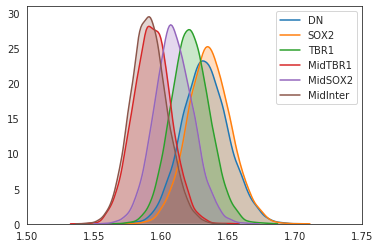

In [981]:
n_samples = 10000
sample_size = 250

names = [n for n in niche_names if n != 'DP']
celltype_ratios = [np.asarray(df['axis_ratio'])[np.where(df['celltype'] == name)] for name in names]
for name, ratios in zip(names, celltype_ratios):
    
    mean_ratios = np.zeros(n_samples)
    for i in range(n_samples):
        ratios_sample = np.random.choice(ratios, sample_size)
        mean_ratios[i] = ratios_sample.mean()
    sns.kdeplot(mean_ratios, shade=True, label=name)
plt.xlim([1.5, 1.75])
plt.legend()
plt.show()

In [207]:
volume = df['volume']
eq_diam = df['eq_diam']
minor_axis = df['minor_length']
major_axis = df['major_length']
axis_ratio = df['axis_ratio']
features = np.stack([volume, eq_diam, minor_axis, major_axis, axis_ratio], axis=1)

pca = PCA(2).fit(features)
x_pca = pca.transform(features)
x_pca.shape, sum(pca.explained_variance_ratio_)

((1702545, 2), 0.9999879790187591)

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


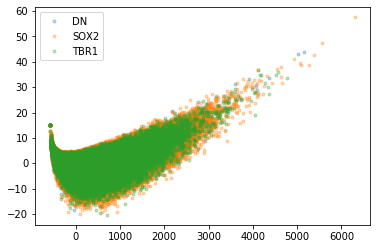

In [208]:
for name in niche_names:
    if name not in ['DN', 'SOX2', 'TBR1']:
        continue
    idx = np.where(df['celltype'] == name)[0]
    plt.plot(x_pca[idx, 0], x_pca[idx, 1], '.', alpha=0.3, label=name)
plt.legend()
plt.show()

In [214]:
n_samples = 400
sample_size = 200

np.random.seed(123)

names = [n for n in niche_names if n != 'DP']
celltype_minor = [np.asarray(df['minor_length'])[np.where(df['celltype'] == name)] for name in names]
celltype_major = [np.asarray(df['major_length'])[np.where(df['celltype'] == name)] for name in names]
celltype_volumes = [np.asarray(df['volume'])[np.where(df['celltype'] == name)] for name in names]

minor = []
major = []
volume = []
celltype = []
for name, minor_lengths, major_lengths, volumes in zip(names, celltype_minor, celltype_major, celltype_volumes):
    if name not in ['DN', 'SOX2', 'TBR1']:
        continue
    
    mean_minor = np.zeros(n_samples)
    mean_major = np.zeros(n_samples)
    mean_volume = np.zeros(n_samples)
    for i in range(n_samples):
        idx = np.arange(len(minor_lengths))
        np.random.shuffle(idx)
        idx = idx[:sample_size]
        mean_minor[i] = minor_lengths[idx].mean()
        mean_major[i] = major_lengths[idx].mean()
        mean_volume[i] = volumes[idx].mean()
    
    minor += list(mean_minor)
    major += list(mean_major)
    volume += list(mean_volume)
    celltype += n_samples * [name]

df_means = pd.DataFrame({'minor_length': np.asarray(minor),
                         'major_length': np.asarray(major),
                         'volume': np.asarray(volume),
                         'celltype': np.asarray(celltype)})

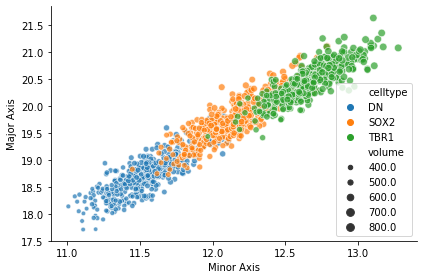

In [216]:
sns.scatterplot(x='minor_length', 
                y='major_length', 
                size='volume', 
                sizes=(20, 60), 
                hue='celltype',
                alpha=0.7,
                data=df_means)

# for name in ['DN', 'SOX2', 'TBR1']:
#     idx = np.where(df_means['celltype'] == name)[0]
#     xs = np.asarray(minor)[idx]
#     ys = np.asarray(major)[idx]
#     m, b, r, p, s = linregress(xs, ys)
#     x = np.linspace(min(xs) * 0.98, max(xs) * 1.02)
#     plt.plot(x, x * m + b, '--', linewidth=2)

# plt.xlim([11, 13.5])
# plt.ylim([17.5, 21])3
plt.legend(loc=4)
plt.tight_layout()
plt.xlabel('Minor Axis')
plt.ylabel('Major Axis')
plt.savefig(os.path.join(working_dir, 'singlecell_morphology.pdf'), bbox_inches='tight')
sns.despine()
plt.show()



Show proximities with color-coded gating strategy

In [982]:
from scout.utils import read_csv
from scout.cyto import randomly_sample

In [983]:
proximities = np.load(os.path.join(working_dir, 'niche_proximities.npy'))
niche_labels = np.load(os.path.join(working_dir, 'niche_labels.npy'))
niche_names = read_csv(os.path.join(working_dir, 'niche_names.csv'))
niche_labels.shape, niche_names, niche_proximities.shape

((1702545,),
 ['DN', 'SOX2', 'TBR1', 'DP', 'MidTBR1', 'MidSOX2', 'MidInter'],
 (1702545, 2))

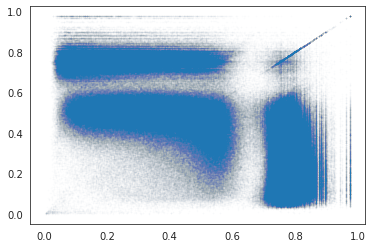

In [984]:
plt.plot(proximities[:, 0], proximities[:, 1], '.', alpha=0.01, markersize=1)
plt.show()

In [985]:
proximity_sample, niche_labels_sample = randomly_sample(100_000, proximities, niche_labels)

In [986]:
from matplotlib.colors import LogNorm, PowerNorm

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


(0, 1)

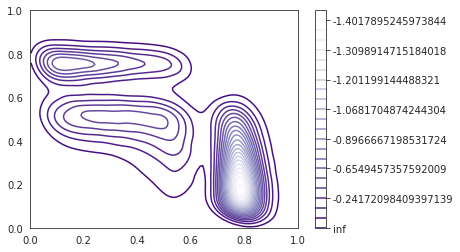

In [987]:
import matplotlib as mpl
from scipy import stats

x = proximity_sample[:, 0]
y = proximity_sample[:, 1]
kde = stats.gaussian_kde([x, y])

xx, yy = np.mgrid[min(x):max(x):(max(x)-min(x))/100, min(y):max(y):(max(y)-min(y))/100]
density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)

sns.set_style("white")
fig, ax = plt.subplots()
cset = ax.contour(xx, yy, density, 25, cmap="Purples_r")
cb = fig.colorbar(cset)
cb.ax.set_yticklabels(map(lambda x: -0.5961573*np.log(float(x.get_text())), 
                          cb.ax.get_yticklabels()))
plt.xlim([0, 1])
plt.ylim([0, 1])

In [988]:
org1_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_15_06_10_AA-4.30.19-org3_488LP13_561LP120_642LP50/dataset'
org2_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_15_06_10_AA-4.30.19-org3_488LP13_561LP120_642LP50/dataset'
org3_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190430_15_06_10_AA-4.30.19-org3_488LP13_561LP120_642LP50/dataset'

proximities1 = np.load(os.path.join(org1_dir, 'niche_proximities.npy'))
proximities2 = np.load(os.path.join(org2_dir, 'niche_proximities.npy'))
proximities3 = np.load(os.path.join(org3_dir, 'niche_proximities.npy'))

niche_labels1 = np.load(os.path.join(org1_dir, 'niche_labels.npy'))
niche_labels2 = np.load(os.path.join(org2_dir, 'niche_labels.npy'))
niche_labels3 = np.load(os.path.join(org3_dir, 'niche_labels.npy'))

proximities1.shape, proximities2.shape, proximities3.shape

((2578864, 2), (2578864, 2), (2578864, 2))

In [989]:
proximity1_sample, niche_labels1_sample = randomly_sample(5_000, proximities1, niche_labels1)
proximity2_sample, niche_labels2_sample = randomly_sample(5_000, proximities2, niche_labels2)
proximity3_sample, niche_labels3_sample = randomly_sample(5_000, proximities3, niche_labels3)

In [990]:
proximity_kde = np.vstack([proximity1_sample, proximity2_sample, proximity3_sample])
labels_kde = np.concatenate([niche_labels1_sample, niche_labels2_sample, niche_labels3_sample])
proximity_kde.shape, labels_kde.shape

((15000, 2), (15000,))

In [638]:
kde = stats.gaussian_kde([proximity_kde[:, 0], proximity_kde[:, 1]])
xx, yy = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)

In [639]:
from matplotlib.patches import Rectangle

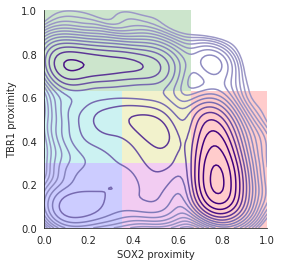

In [640]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(4, 4))
levels = np.logspace(-1.5, np.log(10), 25)

cset = ax.contour(xx, yy, density, levels, cmap="Purples", norm=PowerNorm(0.5, vmin=-1, vmax=3), linewidths=1.5)
# ax.plot([0.35, 0.35], [0, 0.63], 'k-')
# ax.plot([0, 0.66], [0.3, 0.3], 'k-')

low = [0.35, 0.30]
high = [0.66, 0.63]
alpha = 0.2

ax.add_patch(Rectangle((0, 0), low[0], low[1], color='b', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((0, high[1]), high[0], 1 - high[1], color='g', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((0, low[1]), low[0], high[1] - low[1], color='c', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((low[0], low[1]), high[0] - low[0], high[1] - low[1], color='y', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((low[0], 0), high[0] - low[0], low[1], color='m', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((high[0], 0), 1 - high[0], high[1], color='r', alpha=alpha, linewidth=0))

# --low 0.35 0.30 --high 0.66 0.63 -p -

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')
sns.despine()
# plt.savefig(os.path.join(working_dir, '..', 'proximity_cellpopulations_contour.pdf'), bbox_inches='tight')

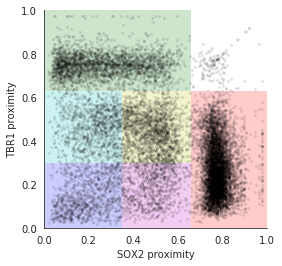

In [641]:
# For supplement
fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(proximity_kde[:, 0], proximity_kde[:, 1], 'k.', markersize=4, alpha=0.08)
ax.add_patch(Rectangle((0, 0), low[0], low[1], color='b', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((0, high[1]), high[0], 1 - high[1], color='g', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((0, low[1]), low[0], high[1] - low[1], color='c', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((low[0], low[1]), high[0] - low[0], high[1] - low[1], color='y', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((low[0], 0), high[0] - low[0], low[1], color='m', alpha=alpha, linewidth=0))
ax.add_patch(Rectangle((high[0], 0), 1 - high[0], high[1], color='r', alpha=alpha, linewidth=0))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('SOX2 proximity')
plt.ylabel('TBR1 proximity')
sns.despine()
plt.savefig(os.path.join(working_dir, '..', 'proximity_cellpopulations_dots.pdf'), bbox_inches='tight')

In [991]:
import pandas as pd

In [992]:
niche_freq = {}
names = []
freq = []
for lbl in np.unique(labels_kde):
    idx = np.where(labels_kde == lbl)[0]
    print(f'Niche {niche_names[lbl]} has {len(idx) / len(labels_kde) * 100:.2f}%')
    if niche_names[lbl] == 'DP':
        continue
    niche_freq[niche_names[lbl]] = len(idx) / len(labels_kde)
    names.append(niche_names[lbl])
    freq.append(len(idx) / len(labels_kde))
df_freq = pd.DataFrame(niche_freq, index=[0])
df_freq.head()

Niche DN has 7.32%
Niche SOX2 has 45.41%
Niche TBR1 has 19.09%
Niche DP has 0.89%
Niche MidTBR1 has 8.38%
Niche MidSOX2 has 6.15%
Niche MidInter has 12.76%


DN      SOX2      TBR1  MidTBR1   MidSOX2  MidInter
0  0.0732  0.454133  0.190867   0.0838  0.061533    0.1276

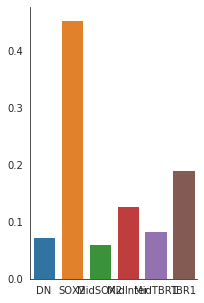

In [993]:
plt.figure(figsize=(3, 5))
sns.barplot(x=names, y=freq, 
            order=['DN', 'SOX2', 'MidSOX2', 'MidInter', 'MidTBR1', 'TBR1'])
sns.despine()
plt.savefig(os.path.join(working_dir, '..', 'cellpopulation_proportions.pdf'), bbox_inches='tight')

ROI with nuclei detections

In [994]:
from scout import io
from skimage import img_as_float32, img_as_uint
from skimage.exposure import rescale_intensity

In [1053]:
# originally done with org1
org_dir = '/data/datasets/organoid_phenotyping/analysis/d35_vs_d60/Lancaster_d35/20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60/dataset/'

In [1054]:
syto = io.open(os.path.join(org_dir, 'syto.zarr'))
tbr1 = io.open(os.path.join(org_dir, 'tbr1.zarr'))
sox2 = io.open(os.path.join(org_dir, 'sox2.zarr'))

centroids = np.load(os.path.join(org_dir, 'centroids.npy'))

syto.shape, tbr1.shape, sox2.shape, centroids.shape

((1500, 3799, 3799), (1500, 3799, 3799), (1500, 3799, 3799), (2173528, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3790, 3801, 3)


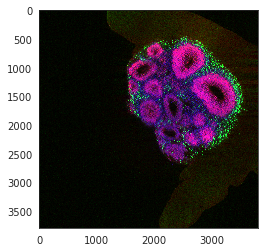

In [1021]:
img = np.dstack([sox2[200], tbr1[200], syto[200]])

print(img.shape)
plt.imshow(img)
plt.show()

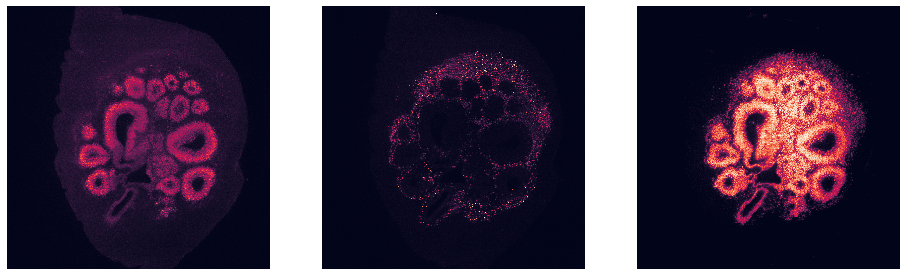

In [1001]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(img[..., 0], clim=[0, 0.2])
plt.axis('off')
plt.subplot(132)
plt.imshow(img[..., 1], clim=[0, 0.03])
plt.axis('off')
plt.subplot(133)
plt.imshow(img[..., 2], clim=[0, 1.0])
plt.axis('off')
plt.show()

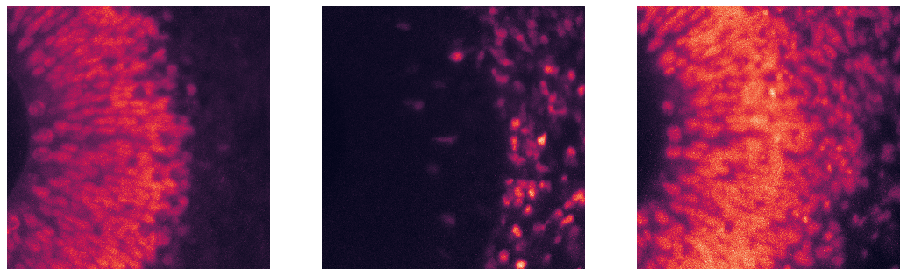

In [1006]:
start = [1800, 2830]
stop = [2100, 3130]

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(img[start[0]:stop[0], start[1]:stop[1], 0], clim=[0, 0.2])
plt.axis('off')
plt.subplot(132)
plt.imshow(img[start[0]:stop[0], start[1]:stop[1], 1], clim=[0, 0.02])
plt.axis('off')
plt.subplot(133)
plt.imshow(img[start[0]:stop[0], start[1]:stop[1], 2], clim=[0, 1.0])
plt.axis('off')
plt.show()

In [746]:
sox2_roi = img[start[0]:stop[0], start[1]:stop[1], 0]
tbr1_roi = img[start[0]:stop[0], start[1]:stop[1], 1]
syto_roi = img[start[0]:stop[0], start[1]:stop[1], 2]

In [747]:
from scout.plot import zprojection
from scout.utils import filter_points_in_box

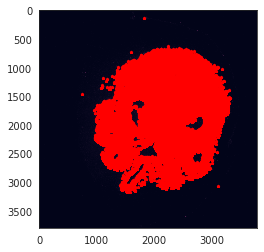

In [748]:
g = zprojection(syto, centroids, zlim=[197, 204], markersize=3)

In [776]:
start = np.array([198, 1800, 2830])
stop = np.array([203, 2100, 3130])

points = filter_points_in_box(centroids, start, stop) - start
points

array([[  4,  38,  23],
       [  4,  10,  46],
       [  3,   0,  38],
       ...,
       [  0, 279, 228],
       [  0, 277, 218],
       [  0, 253, 179]])

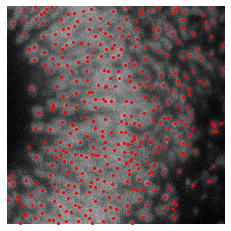

In [781]:
# Save PDF with points overlay
plt.imshow(syto_roi, clim=[0, 0.4], cmap='gray')
plt.plot(points[:, 2], points[:, 1], 'r.', markersize=4)
plt.axis('off')
plt.savefig(os.path.join(working_dir, '..', 'detections.pdf'), bbox_inches='tight')
plt.show()

In [788]:
# Save multichannel TIFF for RGB ImageJ
roi = np.dstack([img_as_uint(sox2_roi), 
                 img_as_uint(tbr1_roi), 
                 img_as_uint(syto_roi)])
io.imsave(os.path.join(working_dir, '..', 'detections_roi.tif'), roi)
roi.shape, roi.dtype

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


((300, 300, 3), dtype('uint16'))

Find ROIs for each subpopulation

In [1055]:
centroids = np.load(os.path.join(org_dir, 'centroids.npy'))
labels = np.load(os.path.join(org_dir, 'niche_labels.npy'))

centroids.shape, labels.shape

((2173528, 3), (2173528,))

In [1056]:
syto = io.open(os.path.join(org_dir, 'syto.zarr'))
tbr1 = io.open(os.path.join(org_dir, 'tbr1.zarr'))
sox2 = io.open(os.path.join(org_dir, 'sox2.zarr'))

syto.shape, tbr1.shape, sox2.shape

((1500, 3799, 3799), (1500, 3799, 3799), (1500, 3799, 3799))

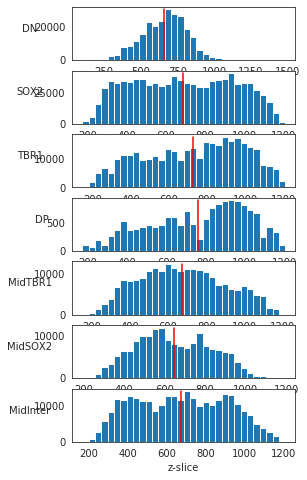

In [1057]:
zaves = []

plt.figure(figsize=(4, 8))
for i, lbl in enumerate(np.unique(labels)):
    label_idx = np.where(labels == lbl)[0]
    points = centroids[label_idx]
    zave = int(points[:, 0].mean())
    zaves.append(zave)
    plt.subplot(7, 1, i+1)
    freq, edges, patches = plt.hist(points[:, 0], bins=32)
    plt.plot([zave, zave], [0, freq.max()], 'r-')
    h = plt.ylabel(niche_names[lbl])
    h.set_rotation(0)
plt.xlabel('z-slice')
plt.show()

In [1058]:
syto_slices = [syto[zave] for zave in zaves[:1]]
tbr1_slices = [tbr1[zave] for zave in zaves[:1]]
sox2_slices = [sox2[zave] for zave in zaves[:1]]

In [1059]:
syto_rescaled = [rescale_intensity(img) for img in syto_slices]
tbr1_rescaled = [rescale_intensity(img) for img in tbr1_slices]
sox2_rescaled = [rescale_intensity(img) for img in sox2_slices]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


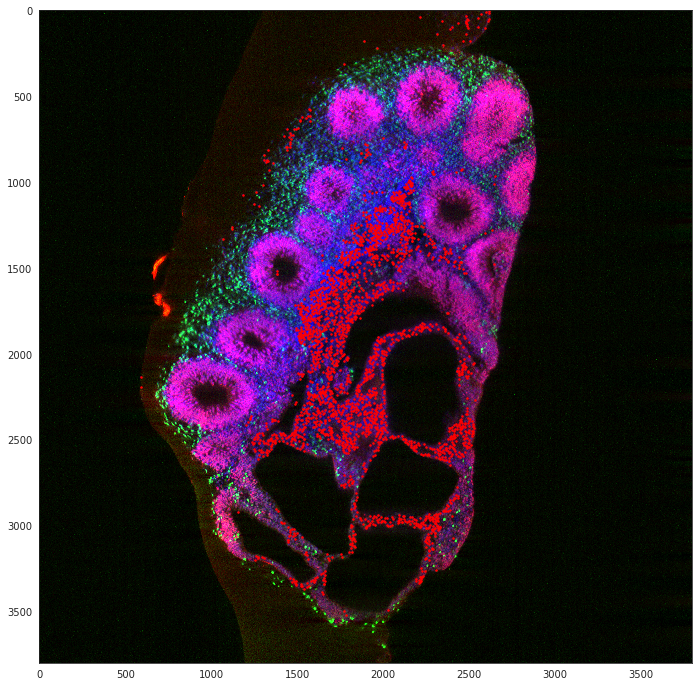

In [1060]:
%matplotlib inline
# DN cells
idx = 0

points = centroids[np.where(labels == idx)[0]]
start = np.array([zaves[idx] - 2, 0, 0], np.int)
stop = np.array([zaves[idx] + 2, *syto.shape[1:]], np.int)
pts = filter_points_in_box(points, start, stop)

plt.figure(figsize=(12, 12))
plt.imshow(np.dstack([sox2_slices[idx], tbr1_slices[idx], syto_slices[idx]]))
plt.plot(pts[:, 2], pts[:, 1], 'r.', markersize=3)
plt.show()
# y = 2000 - 2300
# x = 2500 - 2800

<IPython.core.display.Javascript object>


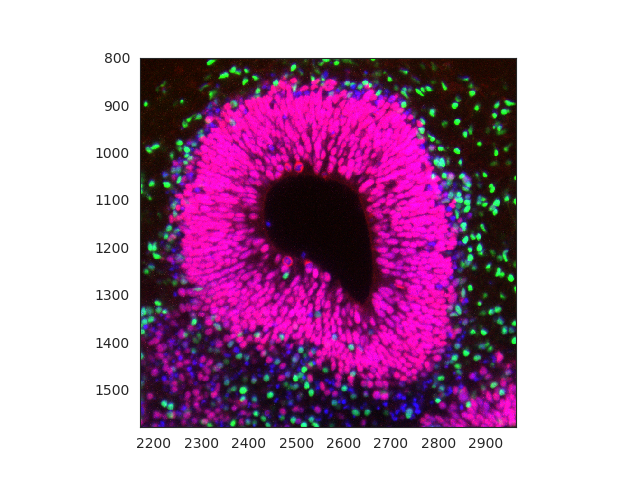

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [857]:
%matplotlib notebook
# SOX2 cells
idx = 1
plt.imshow(np.dstack([sox2_slices[idx]*75, tbr1_slices[idx]*75, syto_slices[idx]*10]))
plt.show()
# y = 800 - 1100
# x = 2400 - 2700

<IPython.core.display.Javascript object>


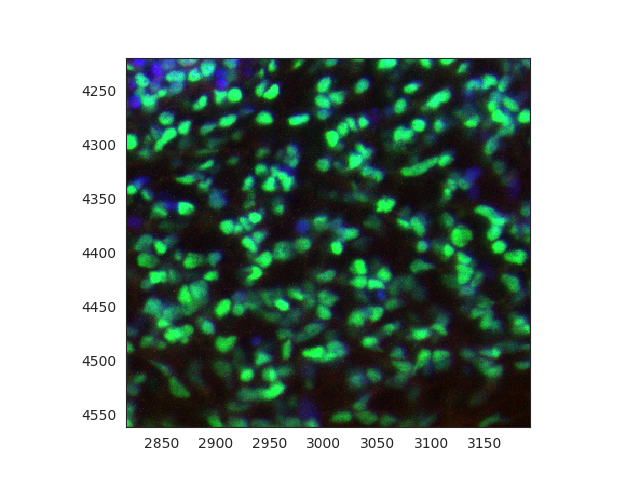

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [859]:
%matplotlib notebook
# TBR1 cells
idx = 2
plt.imshow(np.dstack([sox2_slices[idx]*75, tbr1_slices[idx]*75, syto_slices[idx]*10]))
plt.show()
# y = 4300 - 4600
# x = 2900 - 3200

<IPython.core.display.Javascript object>


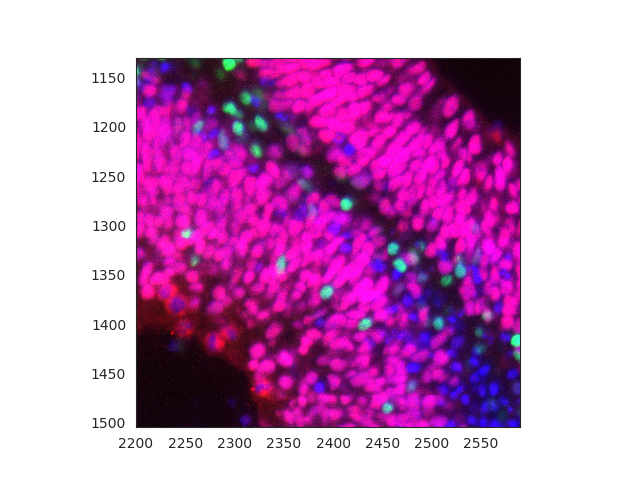

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [861]:
%matplotlib notebook
# Double positive cells
idx = 3
plt.imshow(np.dstack([sox2_slices[idx]*75, tbr1_slices[idx]*75, syto_slices[idx]*10]))
plt.show()
# y = 1200 - 1500
# x = 2200 - 2500

[[  38 2026 1582]
 [  57 2092 1427]
 [  55 2106 1430]
 ...
 [ 910 2398 3177]
 [ 896 2452 3050]
 [ 901 2443 3110]]


<IPython.core.display.Javascript object>


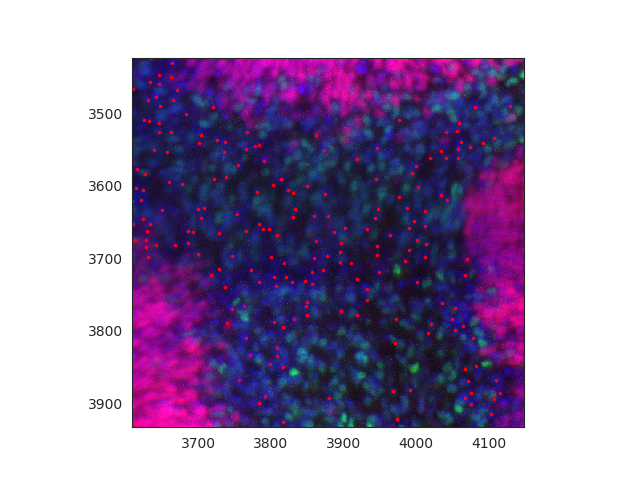

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [872]:
%matplotlib notebook
# TBR1-Adjacent cells

idx = 4

points = centroids[np.where(labels == idx)[0]]
start = np.array([zaves[idx] - 2, 0, 0], np.int)
stop = np.array([zaves[idx] + 2, *syto.shape[1:]], np.int)
pts = filter_points_in_box(points, start, stop)

plt.imshow(np.dstack([sox2_slices[idx]*75, tbr1_slices[idx]*75, syto_slices[idx]*10]))
plt.plot(pts[:, 2], pts[:, 1], 'r.', markersize=3)
plt.show()
# y = 3500 - 3900
# x = 3700 - 4000

<IPython.core.display.Javascript object>


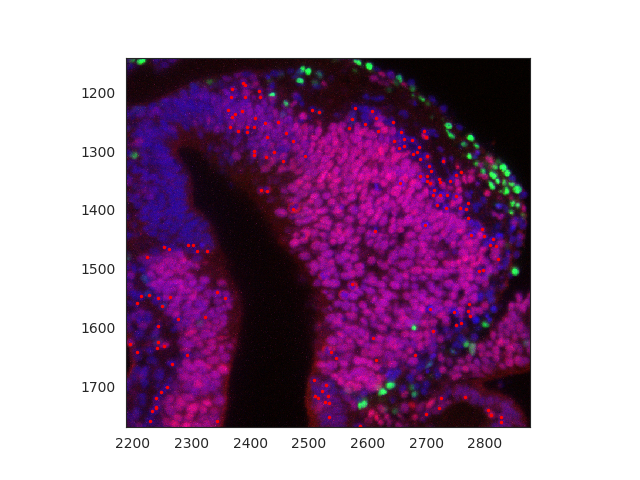

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [873]:
%matplotlib notebook
# SOX2-Adjacent

idx = 5

points = centroids[np.where(labels == idx)[0]]
start = np.array([zaves[idx] - 2, 0, 0], np.int)
stop = np.array([zaves[idx] + 2, *syto.shape[1:]], np.int)
pts = filter_points_in_box(points, start, stop)

plt.imshow(np.dstack([sox2_slices[idx]*75, tbr1_slices[idx]*75, syto_slices[idx]*10]))
plt.plot(pts[:, 2], pts[:, 1], 'r.', markersize=3)
plt.show()
# y = 1200 - 1500
# x = 2300 - 2600

<IPython.core.display.Javascript object>


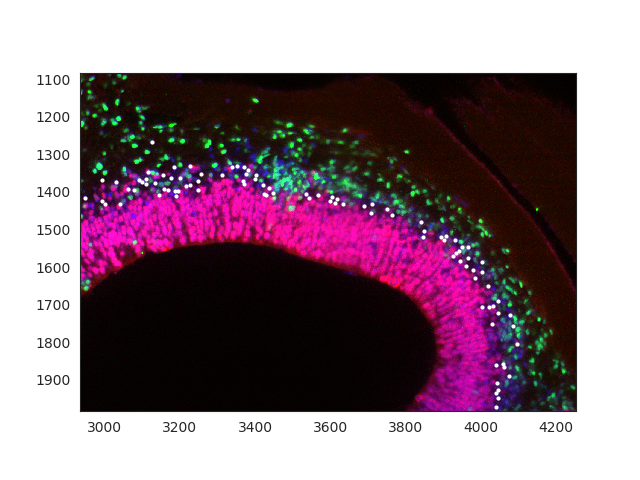

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [876]:
%matplotlib notebook
# Co-Adjacent

idx = 6

points = centroids[np.where(labels == idx)[0]]
start = np.array([zaves[idx] - 2, 0, 0], np.int)
stop = np.array([zaves[idx] + 2, *syto.shape[1:]], np.int)
pts = filter_points_in_box(points, start, stop)

plt.imshow(np.dstack([sox2_slices[idx]*75, tbr1_slices[idx]*75, syto_slices[idx]*10]))
plt.plot(pts[:, 2], pts[:, 1], 'w.', markersize=4)
plt.show()
# y = 1200 - 1500
# x = 3100 - 3400

In [ ]:
# DN: y = 2000 - 2300, x = 2500 - 2800
# SOX2: y = 800 - 1100, x = 2400 - 2700
# TBR1: y = 4300 - 460, x = 2900 - 3200
# DP: y = 1200 - 1500, x = 2200 - 2500
# TBR1-Adj y = 3500 - 3900, x = 3700 - 4000
# SOX2-Adj = 1200 - 1500, x = 2300 - 2600
# Co-adjacent: y = 1200 - 1500, x = 3100 - 3400

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


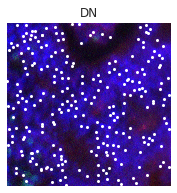

IndexError: list index out of range

In [1067]:
%matplotlib inline

del start
del stop

dz = 2
starts = np.array([[2200, 1600],
                   [800, 2400],
                   [4300, 2900],
                   [1000, 2200],
                   [3600, 3750],
                   [1180, 2300],
                   [1200, 3100]], np.int)
stops = np.array([[2500, 1900],
                  [1100, 2700],
                  [4600, 3200],
                  [1300, 2500],
                  [3900, 4050],
                  [1480, 2600],
                  [1500, 3400]], np.int)

for k, (start, stop) in enumerate(zip(starts, stops)):
    
    sox2_img = utils.extract_box(sox2_slices[k], start, stop)
    tbr1_img = utils.extract_box(tbr1_slices[k], start, stop)
    syto_img = utils.extract_box(syto_slices[k], start, stop)
    
    points = centroids[np.where(labels == k)[0]]
    start3d = np.array([zaves[k] - dz, *start], np.int)
    stop3d = np.array([zaves[k] + dz, *stop], np.int)
    
    pts = filter_points_in_box(points, start3d, stop3d) - start3d
    
    rgb_img = np.dstack([sox2_img*0.8, tbr1_img*0.8, syto_img*1.2])
    
    plt.figure(figsize=(6,3))
    plt.imshow(rgb_img)
    plt.plot(pts[:, 2], pts[:, 1], 'w.', markersize=4)
    plt.title(niche_names[k])
    plt.axis('off')
    plt.savefig(os.path.join(working_dir, '..', f'niche_{niche_names[k]}.pdf'), bbox_inches='tight')
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


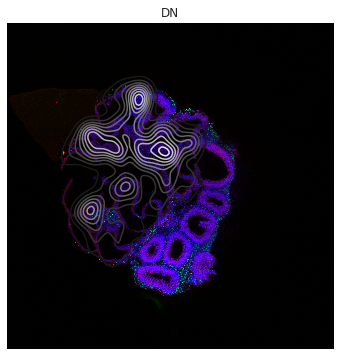

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


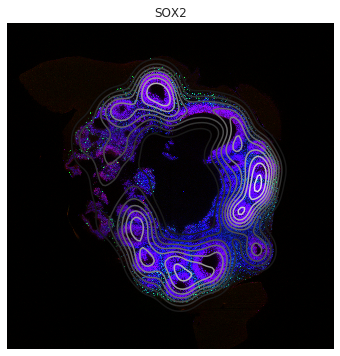

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


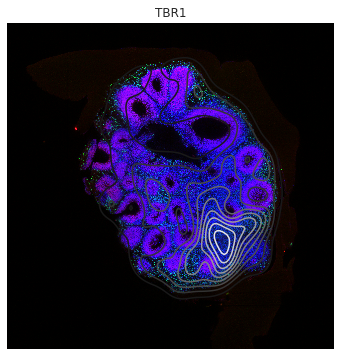

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


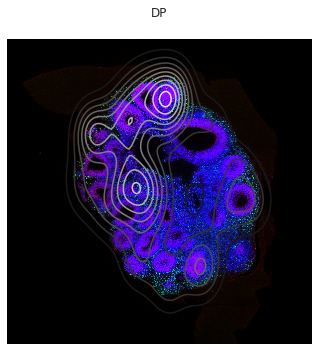

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


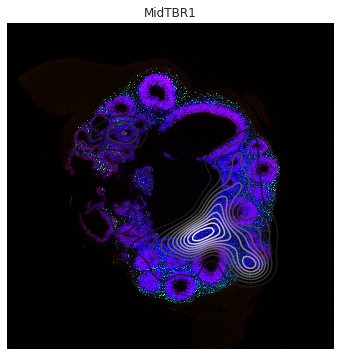

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


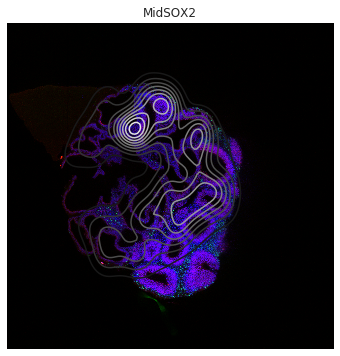

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


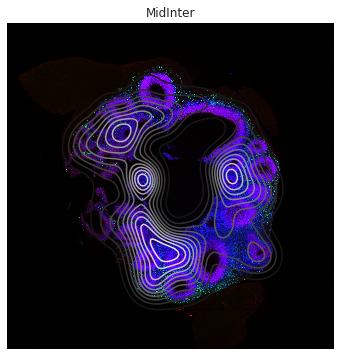

In [970]:
for k, (start, stop) in enumerate(zip(starts, stops)):
    
    sox2_img = sox2_slices[k]
    tbr1_img = tbr1_slices[k]
    syto_img = syto_slices[k]
    
    points = centroids[np.where(labels == k)[0]]
    start3d = np.array([zaves[k] - dz, 0, 0], np.int)
    stop3d = np.array([zaves[k] + dz, *syto.shape[1:]], np.int)
    
    pts = filter_points_in_box(points, start3d, stop3d)
    
    rgb_img = np.dstack([40*sox2_img, 50*tbr1_img, 15*syto_img])
    
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_img)
    sns.kdeplot(pts[:, 2], pts[:, 1], cmap='gray')
#     plt.gca().invert_yaxis()
    plt.axis('off')
    plt.title(niche_names[k])
    plt.show()